<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing-Tutorial/blob/main/TestCollabMiSiCNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries and Set up neccessary Flags 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  5 19:13:50 2021

@author: behnood
"""

#from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib inline
# from numpy import linalg as LA
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
#from models import *
#import math
import torch
import torch.optim
import torch.nn as nn
!cp /content/drive/MyDrive/Colab/MiSiCNet-main/MiSiCNet-main/UtilityMine.py /content
from UtilityMine import *
# from VCA import *
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
PLOT = True
save_result=True
#%% Load image
import scipy.io
import scipy.linalg
from tqdm import tqdm

Importing data

In [ ]:

#%%
fname2  = "/content/drive/MyDrive/Colab/MiSiCNet-main/MiSiCNet-main/HS Data/Apex/Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
rmax=4# Number of Endmemebrs # E_np.shape[1] 
#%%


Network & Training 

  0%|          | 0/1 [00:00<?, ?it/s]

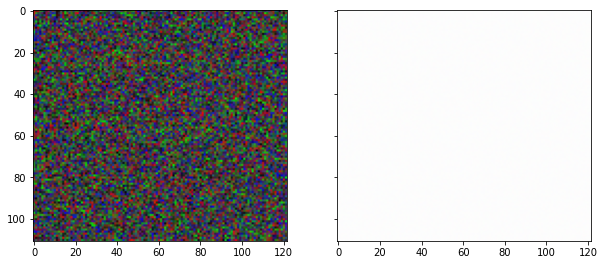


100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


In [ ]:
tol2=1 # Number of runs; Set this to 5 or 10 and take the average to reproduce the results in the manuscript 
for fi in tqdm(range(1)):
    for fj in tqdm(range(tol2)):
            #%%
        #img_noisy_np = get_noisy_image(img_np_gt, 1/10)
        img_noisy_np = img_np_gt# add_noise(img_np_gt, 1/npar[0,fi])#11.55 20 dB, 36.7 30 dB, 116.5 40 dB
        #print(compare_snr(img_np_gt, img_noisy_np))
        img_resh=np.reshape(img_noisy_np,(p1,nr1*nc1))
        V, SS, U = scipy.linalg.svd(img_resh, full_matrices=False)
        PC=np.diag(SS)@U
        # img_resh_DN=V[:,:rmax]@PC[:rmax,:]
        img_resh_DN=V[:,:rmax]@V[:,:rmax].transpose(1,0)@img_resh
        img_resh_np_clip=np.clip(img_resh_DN, 0, 1)
        II,III = Endmember_extract(img_resh_np_clip,rmax)
        E_np1=img_resh_np_clip[:,II]
        #%% Set up Simulated 
        INPUT = 'noise' # 'meshgrid'
        pad = 'reflection'
        need_bias=True
        OPT_OVER = 'net' 
        
        # 
        LR1 = 0.001
        show_every = 500
        exp_weight=0.99
        
        num_iter1 = 80
        input_depth =  img_noisy_np.shape[0]
        class CAE_EndEst(nn.Module):
            def __init__(self):
                super(CAE_EndEst, self).__init__()
                self.conv1 = nn.Sequential(
                    conv(input_depth, 256,3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv2 = nn.Sequential(
                    conv(256, 256,3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv3 = nn.Sequential(
                    conv(input_depth, 4, 1,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(4,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.dconv2 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(260, 256, 3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(256,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
        
                self.dconv3 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(256, rmax, 3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(rmax,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.Softmax(),
                )
                self.dconv4 = nn.Sequential(
                    nn.Linear(rmax, p1,bias=False),
                )
            def forward(self, x):
                x1 = self.conv3(x)
                x = self.conv1(x)
                x = torch.cat([x,x1], 1)
                x = self.dconv2(x)
                x2 = self.dconv3(x)
                x3 = torch.transpose(x2.view((rmax,nr1*nc1)),0,1)
                x3 = self.dconv4(x3)
                return x2,x3

        net1 = CAE_EndEst()
        net1.cuda()
        
        # Loss
        def my_loss(target, End2, lamb, out_):
            loss1 = 0.5*torch.norm((out_.transpose(1,0).view(1,p1,nr1,nc1) - target), 'fro')**2
            O = torch.mean(target.view(p1,nr1*nc1),1).type(dtype).view(p1,1)
            B = torch.from_numpy(np.identity(rmax)).type(dtype)
            loss2 = torch.norm(torch.mm(End2,B.view((rmax,rmax)))-O, 'fro')**2
            return loss1+lamb*loss2
            
        img_noisy_torch = torch.from_numpy(img_resh_DN).view(1,p1,nr1,nc1).type(dtype)
        net_input1 = get_noise(input_depth, INPUT,
            (img_noisy_np.shape[1], img_noisy_np.shape[2])).type(dtype).detach()
        E_torch = torch.from_numpy(E_np1).type(dtype)
        #%%
        # net_input_saved = net_input1.detach().clone()
        # noise = net_input1.detach().clone()
        out_avg = True
        
        i = 0
        def closure1():
            
            global i, out_LR_np, out_avg, out_avg_np, Eest
            
            out_LR,out_spec = net1(net_input1)
#            out_HR=torch.mm(E_torch.view(p1,rmax),out_LR.view(rmax,nr1*nc1))
            # Smoothing
            if out_avg is None:
                out_avg = out_LR.detach()
                # out_HR_avg = out_HR.detach()
            else:
                out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)
                # out_HR_avg = out_HR_avg * exp_weight + out_HR.detach() * (1 - exp_weight)

        #%%
            total_loss = my_loss(img_noisy_torch, net1.dconv4[0].weight,100,out_spec)
            total_loss.backward()
         
          

            # print ('Iteration %05d    Loss %f   RMSE_LR: %f   RMSE_LR_avg: %f  SRE: %f SRE_avg: %f' % (i, total_loss.item(), RMSE_LR, RMSE_LR_avg, SRE, SRE_avg), '\r', end='')
            if  PLOT and i % show_every == 0:
                out_LR_np = out_LR.detach().cpu().squeeze().numpy()
                out_avg_np = out_avg.detach().cpu().squeeze().numpy()
                out_LR_np = np.clip(out_LR_np, 0, 1)
                out_avg_np = np.clip(out_avg_np, 0, 1)    
                f, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
                ax1.imshow(np.stack((out_LR_np[2,:,:],out_LR_np[1,:,:],out_LR_np[0,:,:]),2))
                ax2.imshow(np.stack((out_avg_np[2,:,:],out_avg_np[1,:,:],out_avg_np[0,:,:]),2))
                plt.show()                 
            i += 1       
            return total_loss
        net1.dconv4[0].weight=torch.nn.Parameter(E_torch.view(p1,rmax))       
        p11 = get_params(OPT_OVER, net1, net_input1)
        optimizer = torch.optim.Adam(p11, lr=LR1, betas=(0.9, 0.999), eps=1e-8,
                  weight_decay= 0, amsgrad=False)
        for j in range(num_iter1):
                optimizer.zero_grad()
                closure1()  
                optimizer.step()
                net1.dconv4[0].weight.data[net1.dconv4[0].weight <= 0] = 0
                net1.dconv4[0].weight.data[net1.dconv4[0].weight >= 1] = 1
                if j>0:
                  Eest=net1.dconv4[0].weight.detach().cpu().squeeze().numpy()
                  if PLOT and j % show_every== 0: 
                    plt.plot(Eest)
                    plt.show()
                  
        out_avg_np = out_avg.detach().cpu().squeeze().numpy()

Save the results

In [ ]:
           #%%
        if  save_result is True:
                  scipy.io.savemat("drive/MyDrive/Colab/Result/EestdB%01d%01d.mat" % (fi+2, fj+1),
                                    {'Eest%01d%01d' % (fi+2, fj+1):Eest})
                  scipy.io.savemat("drive/MyDrive/Colab/Result/out_avg_npdB%01d%01d.mat" % (fi+2, fj+1),
                                    {'out_avg_np%01d%01d' % (fi+2, fj+1):out_avg_np.transpose(1,2,0)})